# Abstract

В 7 разделе статьи проведены следующие эксперименты.

## Logistic regression

Method: ```Adam```

Model: Logistic regression

Datasets:
 - Sensorless
 - Aloi
 - DNA
 - Glass
 - Iris
 - Letter
 - Pendigits
 - smallNORB
 - USPS
 - Vehicle
 - Vowel
 - Vine

Source: [LIBSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/)

Обучение длилось 100 эпох.

На 60, 80 и 95 эпохах скорость обучения уменьшалась в 10 раз.

Для Adam скорость обучения была подобрана линейным поиском.

Во всех случаях ```D-Adapt Adam``` дает не худшую точность или лучшую точность до $5\%$, чем ```Adam```.

## Image classification

Method: ```SGD```

Models (corresponding to datasets):
 - WRN-16-8
 - DenseNet
 - ResNet-50

Datasets:
 - CIFAR10
 - CIFAR100
 - ImageNet 2012

Sources:
 - [CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html)
 - [ILSVRC](https://image-net.org/challenges/LSVRC/index.php)

Во всех случаях ```D-Adapt SGD``` показал не худшую точность, чем ```SGD```.

## Natural language processing

Method: ```Adam```

Models (corresponding to datasets):
 - LSTM
 - RoBERTa
 - GPT Transformer

Datasets:
 - IWSLT14
 - BookWiki
 - Bookwiki

Sources: **NA**

Во всех случаях ```D-Adapt Adam``` получил сопоставимый коэффициент неопределенности с ```Adam```.

## Further experiments

Method: ```SGD``` for COCO and ```Adam``` for others

Models (corresponding to datasets):
 - vit_tiny_patch16_224
 - Faster-RCNN with pretrained ResNeXt-101-32x8d
 - VarNet 2.0
 - DLRM

Datasets:
 - ImageNet 2012
 - COCO 2017
 - fastMRI Knee
 - Criteo Kaggle

Sources:
 - [ILSVRC](https://image-net.org/challenges/LSVRC/index.php)
 - [COCO](https://cocodataset.org/#download)
 - [fastMRI](https://fastmri.med.nyu.edu/)
 - [Criteo Kaggle](https://www.kaggle.com/datasets/mrkmakr/criteo-dataset)

vit_tiny_patch16_224 обучилась с помощью ```D-Adapt Adam``` на ImageNet хуже, чем с помощью ```Adam```.

В остальных случаях адаптированные методы показали сопоставимое качество обучения.

## Reproduction

Проведем следующие эксперименты:
 - Logistic regression: повторим результаты на DNA, проведем обучение на mushrooms, добавим в сравнение ```Adagrad```
 - Image classification: приведенные в статье модели достаточно тяжелые, поэтому обучим более простую модель на CIFAR10
 - Natural language processing: повторим результаты на BookWiki, используя GPT Transformer
 - Further experiments: повторим результаты на Criteo Kaggle

# Set-up

In [1]:
!pip install torchvision

In [2]:
from sklearn.datasets import load_svmlight_file
from typing import Callable, Iterator
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm

import dadaptation as dad
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set_theme(style="whitegrid", palette="Set2")

In [4]:
def train_model(
    model: nn.Module, optimizer: torch.optim.Optimizer, train_loader: DataLoader, **loss_kwargs
) -> None:
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, labels)
        loss.backward(**loss_kwargs)
        optimizer.step()

In [5]:
def eval_model(model: nn.Module, test_loader: DataLoader) -> tuple[float, float]:
    correct = 0
    total = 0
    val_loss = 0.0
    loss_fn = nn.CrossEntropyLoss()
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += torch.sum(predicted == labels).item()
            val_loss += loss_fn(outputs, labels).item()

    return val_loss, correct / total

In [6]:
def check_optimizers(
    optimizers: list[
        tuple[str, Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer]]
    ],
    epochs: int,
    model_class: Callable[[], nn.Module],
    train_loader: DataLoader,
    test_loader: DataLoader,
    lr_decay = (lambda k: 1)
):
    results_dict = {}
    for name, optimizer_lambda in optimizers:
        test_losses = []
        accuracies = []
        time_logs = []
        torch.manual_seed(52)
        model = model_class().to(DEVICE)
        optimizer = optimizer_lambda(model.parameters())

        loss, accuracy = eval_model(model, test_loader)
        test_losses.append(loss)
        accuracies.append(accuracy)

        start_time = time.time()
        with tqdm(range(epochs), desc=name) as loop:
            for epoch in loop:
                decay = lr_decay(epoch)
                for param_group in optimizer.param_groups:
                    param_group['lr'] = param_group['lr'] * decay
                train_model(model, optimizer, train_loader, create_graph=True)
                # Подсчет функции потерь и accuracy
                loss, accuracy = eval_model(model, test_loader)
                # Произведите логирование
                test_losses.append(loss)
                accuracies.append(accuracy)
                # torch.cuda.synchronize()

                time_logs.append(time.time() - start_time)
                loop.set_postfix({"Loss": loss, "Accuracy": accuracy})
                torch.save(model.state_dict(), "./Models/" + name)
        results_dict[name] = {
            "Epoch": list(range(epochs + 1)),
            "Time": time_logs,
            "Test Loss": test_losses,
            "Accuracy": accuracies,
        }
    return results_dict

In [7]:
def GetLoader(
    X: np.ndarray, y: np.ndarray, batch_size: int = 16, shuffle: bool = True
) -> torch.utils.data.dataloader.DataLoader:
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.int64) - 1
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# 1 Logistic regression

In [8]:

optimizers = [("Adam", lambda params: torch.optim.Adam(params)),
              ("Adagrad", lambda params: torch.optim.Adagrad(params)),
              ("D-Adapt Adam", lambda params: dad.DAdaptAdam(params)),
              ("D-Adapt Adagrad", lambda params: dad.DAdaptAdaGrad(params))]

## 1.1 DNA

In [9]:
train_path = "./Datasets/dna.scale.tr"
test_path = "./Datasets/dna.scale.t"

X_train, y_train = load_svmlight_file(train_path)
X_test, y_test = load_svmlight_file(test_path)

n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))

train_loader = GetLoader(X_train.toarray(), y_train, batch_size=16, shuffle=False)
test_loader = GetLoader(X_test.toarray(), y_test, batch_size=256, shuffle=False)

class model_class(nn.Sequential):
    def __init__(self):
        super().__init__(torch.nn.Linear(n_features, n_classes))

def lr_decay(k):
    if k in [60, 80, 95]:
        return 0.1
    return 1

In [10]:
results = check_optimizers(optimizers, 100, model_class, train_loader, test_loader, lr_decay)

Adam:   0%|          | 0/100 [00:00<?, ?it/s]c:\Users\adaiv\Vault\Education\Semester 5\Optimization methods Semester 5 Article D Adaptation\.venv\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\engine.cpp:1206.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
D-Adapt Adagrad: 100%|██████████| 100/100 [00:05<00:00, 17.63it/s, Loss=1.32, Accuracy=0.922]


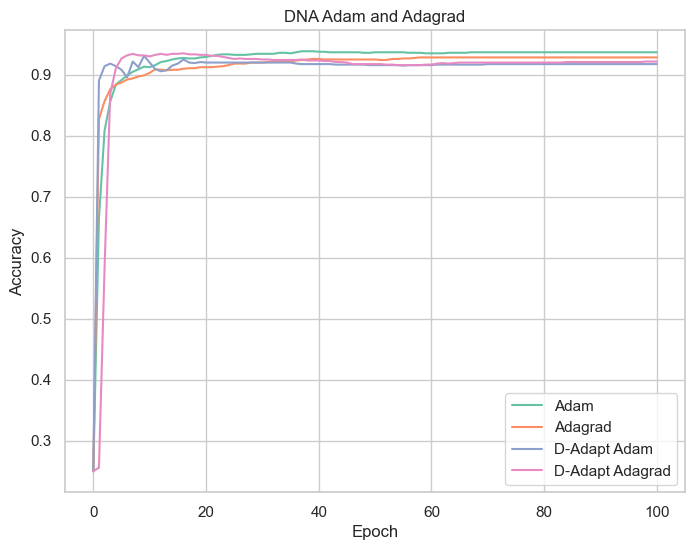

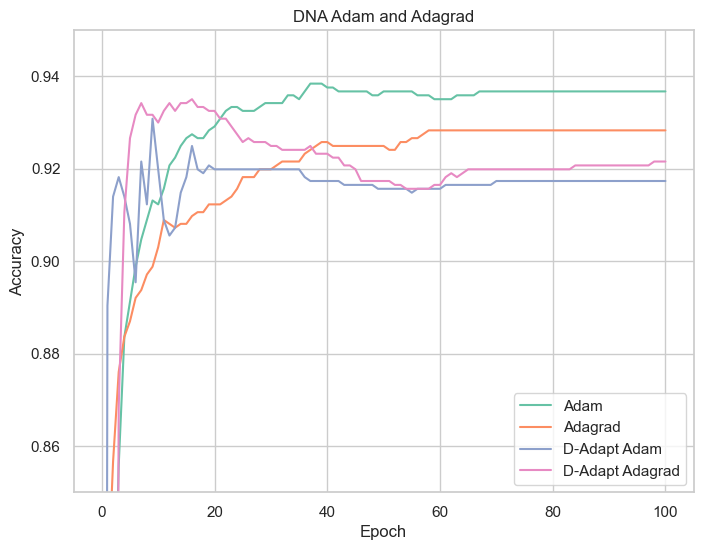

In [13]:
plt.figure(figsize=(8, 6))
for title in results:
    data = results[title]
    plt.plot(data["Accuracy"], label=title)
plt.legend()
plt.title("DNA Adam and Adagrad")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8, 6))
for title in results:
    data = results[title]
    plt.plot(data["Accuracy"], label=title)
plt.legend()
plt.ylim(0.85, 0.95)
plt.title("DNA Adam and Adagrad")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## 1.2 mushrooms

In [14]:
path = "./Datasets/mushrooms.txt"
data = load_svmlight_file(path)
X, y = data[0].toarray(), data[1]
y = y - 1
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.int64))
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(52))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

n_features = X.shape[1]
n_classes = len(np.unique(y))

class model_class(nn.Sequential):
    def __init__(self):
        super().__init__(torch.nn.Linear(n_features, n_classes))

In [15]:
results = check_optimizers(optimizers, 25, model_class, train_loader, test_loader, lr_decay)

Adam:   0%|          | 0/25 [00:00<?, ?it/s]

D-Adapt Adagrad: 100%|██████████| 25/25 [00:05<00:00,  4.96it/s, Loss=0.00304, Accuracy=1]  


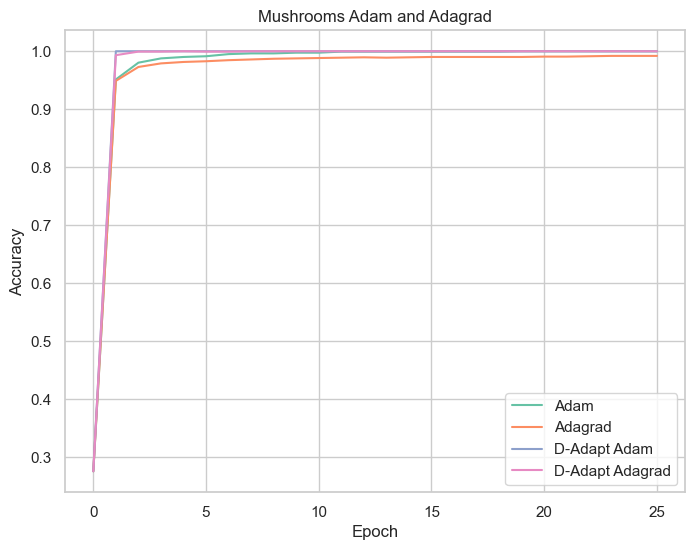

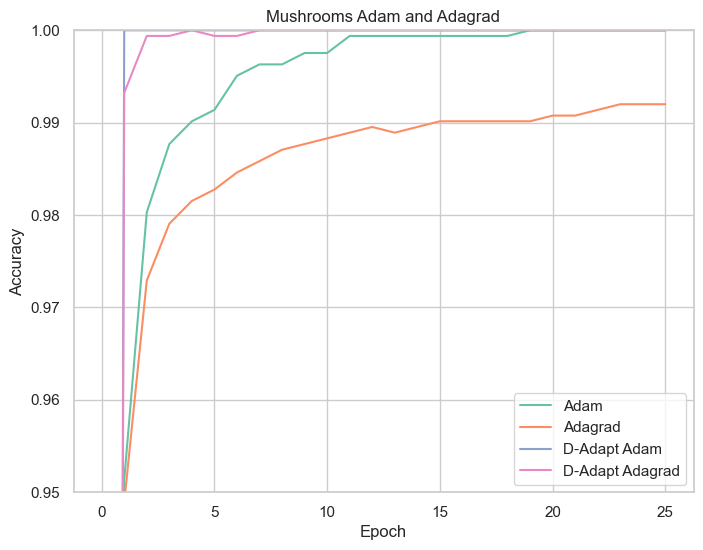

In [19]:
plt.figure(figsize=(8, 6))
for title in results:
    data = results[title]
    plt.plot(data["Accuracy"], label=title)
plt.legend()
plt.title("Mushrooms Adam and Adagrad")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8, 6))
for title in results:
    data = results[title]
    plt.plot(data["Accuracy"], label=title)
plt.legend()
plt.ylim(0.95, 1)
plt.title("Mushrooms Adam and Adagrad")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# 2 Image classification

In [20]:
optimizers = [# ("SGD", lambda params: torch.optim.Adam(params)),
              ("D-Adapt SGD", lambda params: dad.DAdaptSGD(params))]

In [21]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
train_dataset = torchvision.datasets.CIFAR10(
    root="./Datasets", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root="./Datasets", train=False, download=True, transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [22]:
class CifarNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [23]:
results = check_optimizers(optimizers, 15, CifarNet, train_loader, test_loader)

D-Adapt SGD: 100%|██████████| 15/15 [03:18<00:00, 13.22s/it, Loss=92.5, Accuracy=0.1]  


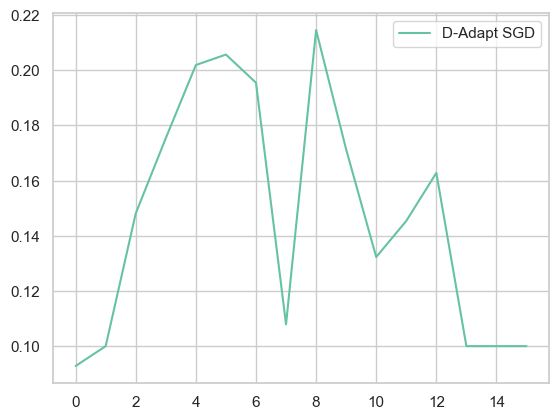

In [24]:
for title in results:
    data = results[title]
    plt.plot(data["Accuracy"], label=title)
plt.legend()
# plt.ylim(0.8, 1)
plt.show()

# 3 Natural language processing

# 4 Recommendation system